<center><h1>Linear Discriminants: logistic regression</h1></center>

$%\newcommand{\mathbf{x}}{\mathbf{x}}\newcommand{\mathbf{w}}{\mathbf{w}}\newcommand{\mathcal{C}}{\mathcal{C}}\newcommand{\mathbf{w}x}{\mathbf{w}^\top\mathbf{x}}\newcommand{\mathcal{C}lass}{\mathcal{C}}$



# Some background

As we have seen in the lecture, the logistic regression models the probability of a class label $\mathcal{C}$ given a datapoint $p(\mathcal{C}|\mathbf{x})$ as:
$$p(\mathcal{C}|\mathbf{x}) = \sigma(\mathbf{w}^\top\mathbf{x}) = \frac{1}{1+e^{-\mathbf{w}^\top\mathbf{x}}}$$

In this lab, we shall implement this model.

## Logistic function

First, let us set things up; import the libraries we will need and define a function to plot heatmaps, to be used later.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 5.0) # Set the size of future plots

import time
from IPython import display

xx,yy = np.mgrid[-5:10:.5,-5:10:.5]

def plotHeat(w):
    """ 
    Plot a weight vector w = [w_0,w_1,w_2] as a colour map
    """
    display.clear_output(wait=True)
    display.display(plt.gcf())
    p = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            p[i,j] = sigma(w.dot(np.array([1., xx[i,j], yy[i,j]]))) # You write sigma(a) next
    plt.pcolor(xx,yy,p,cmap='seismic')
    plt.xlim([-5,10])
    plt.ylim([-5,10])
    plt.scatter(d[:,0],d[:,1],20,colours)
    time.sleep(.01)



**Question 1** To get started, let us plot the logistic function $\sigma(a)$ in the range $[-5\dots 5]$ in blue, and its derivative $\frac{\partial}{\partial a} \sigma(a)$ in green. Create a function called ``sigma(a)`` that computes $\sigma(a)$ to do this. The ``plotHeat`` function defined above will use this later in this lab.

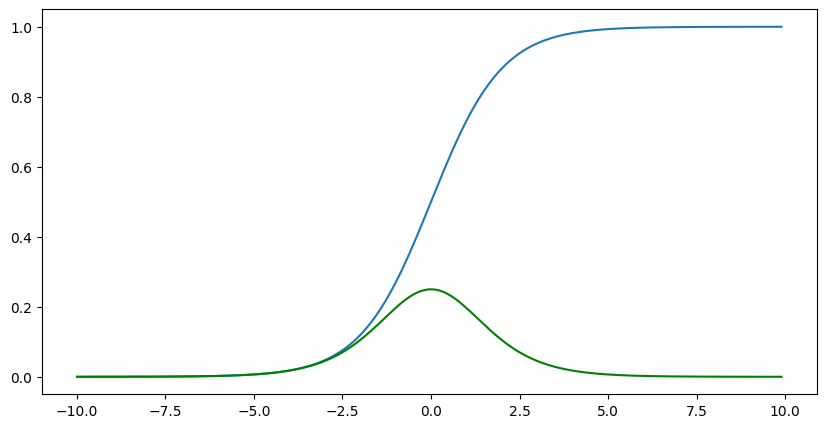

In [3]:
x = np.arange(-10,10,.1)
def sigma(a):
    return 1./(1.+np.exp(-a))

plt.plot(x,sigma(x))
plt.plot(x,sigma(x)*(1-sigma(x)),'g')

## Training data

Next, load the data in the provided data file "*data-2class.npz*", and plot it. Then also plot the discriminant of a logistic regression model with parameters $\mathbf{w} = [ 0,1,1]$ (where the first element of the vector is $w_0$, the bias of the classification)


The discriminant is where the classifier switches from one class to the other. That is, in this case, the line where the probability of both classes is the same: $p(\mathcal{C}=0|\mathbf{x}) = p(\mathcal{C}1|\mathbf{x})$. Since $p(\mathcal{C}=0|\mathbf{x}) = 1-p(\mathcal{C}=1|\mathbf{x})$, we get $p(\mathcal{C}lass=0|\mathbf{x})=p(\mathcal{C}=1|\mathbf{x})=1/2$. So, to plot the discriminant, we set $$p(\mathcal{C}|\mathbf{x})=\frac{1}{1+e^{-\mathbf{w}^\top\mathbf{x}}} = 1/2,$$
or $\exp (\mathbf{w}^\top \mathbf{x}) = 1$ or $\mathbf{w}^\top\mathbf{x} = 0$. In other words, we can plot 
$w_0+w_1x_1 + w_2x_2 = 0$, or $x_1 = -\frac{w_2x_2+w_0}{w_1}$

d (1000, 2)
l (1000, 1)
v (1000, 3)
explanation ()

Two-class artificial dataset

This dataset contains 2D datapoints and corresponding labels. The file contains four 
variables:
    explanation: this text, describing how to use the file
    d:           a matrix where each row is a datapoint
    l:           a vector with as many elements as there are rows in d; containing the labels
    v:           a matrix containing l as first column, and d as second and third column


Only one of the lines below corresponds to the given weights (which are not very good yet). 
The other line is there to show you what a better model would do. Next, we will see
how logistic regression provides you with a good value for those weights.


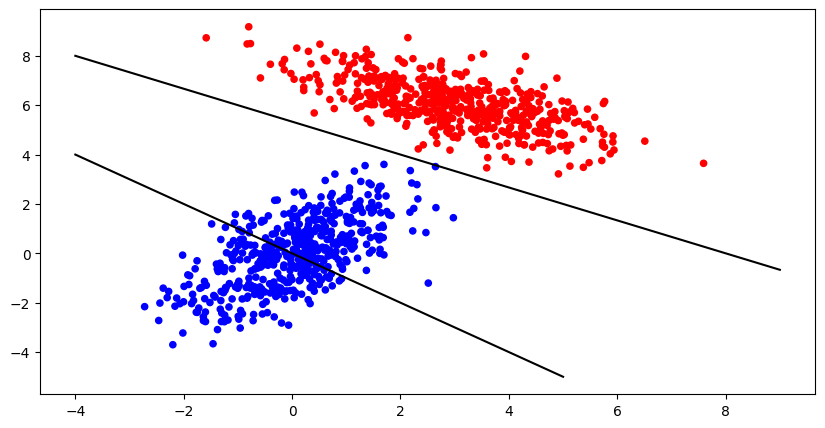

In [4]:
data = np.load("data-2class.npz")
for k in data.keys():
    print(k,data[k].shape)
d = data['d']
l = data['l']
print(data["explanation"])

colours = [ [ 'b', 'r' ][int(x)] for x in np.nditer(l)]

plt.scatter(d[:,0],d[:,1],20,colours)

def plotDisc(w):
    if abs(w[1])>abs(w[2]):
        yr = np.arange(-6,10,1)
        xr = -(w[2]*yr+w[0])/w[1]
        valid  = (xr>-4) & (xr<10)
        plt.plot(xr[valid], yr[valid],'k')
    else:
        xr = np.arange(-4,10,1)
        yr = -(w[1]*xr+w[0])/w[2]
        valid  = (yr>-6) & (yr<10)
        plt.plot(xr[valid], yr[valid],'k')

plotDisc([-8,1.,1.5])
plotDisc([0,1.,1])

print("""

Only one of the lines below corresponds to the given weights (which are not very good yet). 
The other line is there to show you what a better model would do. Next, we will see
how logistic regression provides you with a good value for those weights.""")


## Probability of the given labels for all datapoints

We will now train our logistic regression model on a training dataset. This dataset contains a number of datapoints $\mathbf{x}_1,\dots,\mathbf{x}_N$belonging to two classes and, for each datapoint $\mathbf{x}_n$, the corresponding class label $\mathcal{C}_n$. The training is done by *maximum likelihood*, that is, we maximise the probability of the data given the model. 

## Model

Before we start coding, let's have a closer look at the model. Our labels are $0$ or $1$, representing the two classes. If a datapoint $\mathbf{x}_n$ belongs to class $\mathcal{C}_n=1$, the probability $p(\mathcal{C}_n=1|\mathbf{x}_n) = \sigma(\mathbf{w}^\top\mathbf{x}_n)$; otherwise, the probability $p(\mathcal{C}_n=0|\mathbf{x}_n) = 1-\sigma(\mathbf{w}^\top\mathbf{x})$ (where $\mathbf{x}$ denotes a datapoint which is extended with a constant $1$ as the first dimension, so that the inner product includes the bias $w_0$). We now want the probability of the labels given the data, for the complete training set: $p(\mathcal{C}_1,\dots,\mathcal{C}_N|\mathbf{x}_1,\dots,\mathbf{x}_N)$. Remember that the probability of the union of two independent events is $p(a,b)=p(a)\,p(b)$. Using the fact that the labels are $0$ and $1$ (and that $x^0=1$ and $x^1=x$, we can then write this as 
$$p(\mathcal{C}_1\dots\mathcal{C}_n|\mathbf{x}_1\dots\mathbf{x}_n,\mathbf{w}) = \prod_{n=1}^N \sigma(\mathbf{w}^\top\mathbf{x}_n)^{\mathcal{C}_n}\,(1-\sigma(\mathbf{w}^\top\mathbf{x}_n))^{1-\mathcal{C}_n}$$

**Question 1:** For the provided dataset, compute this probability when the model weights are $\mathbf{w} = [ 0,-1,-1]$. Is the computed answer what you expected? Is it exactly correct?
Think about how an algorithm could find the maximum of this function. What does the gradient of this probability look like (that is, if I changed the value of $\mathbf{w}$ a little bit, how would the probability change)?

In [5]:

prob = 1.
w = np.array([0,-1,-1])
#extend the data with a 1 in column 0
xt = np.ones((d.shape[0],d.shape[1]+1))
xt[:,1:] = d
for x,c in zip(xt,l):
#    print prob
    prob *= float(sigma(w.dot(x)))**c * float(1.-sigma(w.dot(x)))**(1-c)
print("probability is: ", prob)

print ('''
The probability is too small to be represented as a "float" 
(double-precision real value), and is approximated as being 
zero by the computer. This is a problem, because it means 
that the computer cannot compute the gradient: changing w does
not change the probability (as computed by the computer)
''')



probability is:  [0.]

The probability is too small to be represented as a "float" 
(double-precision real value), and is approximated as being 
zero by the computer. This is a problem, because it means 
that the computer cannot compute the gradient: changing w does
not change the probability (as computed by the computer)



Dealing with the joint probability is complicated, as 1) its value can become very small, easily too small for a computer to represent it accurately, and 2) taking the gradient of this joint probability with respect to $\mathbf{w}$ makes the contribution of every datapoint to the gradient depend on every other datapoint's value.

# Gradient

So instead, we will define an error function which is the natural logarithm of the likelihood.

**Question 2:** Write down the equation for the error function $E(\mathbf{w})$ as a function of the parameters, which is defined [$\triangleq$: "equals, by definition"] as $E(\mathbf{w}) \triangleq -\log p(\mathcal{C}_1,\dots,\mathcal{C}_N|\mathbf{x}_1,\dots,\mathbf{x}_N,\mathbf{w})$, the logarithm of the probability of all the labels given all the datapoints, in analytical form. The basis of the logarithm doesn't matter, so for convenience the natural logarithm is used. 

Remember that the datapoints are assumed to be independent and identically distributed (i.i.d.), so that the probability of one label given the corresponding datapoint is independent of the rest of the data. Simplify this equation as much as possible, so as to make its computation as efficient as possible, and its gradient convenient to derive.





\begin{align}
E(\mathbf{w})
&= -\log \prod_{n=1}^N \sigma(\mathbf{w}^\top\mathbf{x}_n)^{\mathcal{C}_n}\,(1-\sigma(\mathbf{w}^\top\mathbf{x}_n))^{1-\mathcal{C}_n}\\
&= -\sum_n \mathcal{C}_n\log \frac{1}{1+e^{-\mathbf{w}x}} + (1-\mathcal{C}_n) \log (1-\frac{1}{1+e^{-\mathbf{w}x}}) \\
&= \sum_n \mathcal{C}_n \log (1+e^{-\mathbf{w}x}) - (1-\mathcal{C}_n) \log \frac{1+e^{-\mathbf{w}x}-1}{1+e^{-\mathbf{w}x}} \\
&= \sum_n \mathcal{C}_n \log (1+e^{-\mathbf{w}x}) - (1-\mathcal{C}_n) (-\mathbf{w}x - \log(1+e^{-\mathbf{w}x})) \\ 
&= \sum_n \mathcal{C}_n \log (1+e^{-\mathbf{w}x}) + \mathbf{w}x + \log(1+e^{-\mathbf{w}x}) - \mathcal{C}_n\mathbf{w}x - \mathcal{C}_n \log(1+e^{-\mathbf{w}x}) \\
&= \sum_n (1-\mathcal{C}_n)\mathbf{w}x + \log(1+e^{-\mathbf{w}x})
\end{align}



**Question 3:** Compute the actual value of the error function for the given dataset and weight $w=[0,-1,-1]$.

Notice that this function does not contain products of probabilities anymore, but sums of log-probabilities, thus making the derivative of the joint log-probability with respect of each of the weights a sum of derivatives of the log-probabilities of single datapoints. The logarithm is what's called a "monotonically increasing function", which means that if $x_1 > x_2$ then $f(x_1) > f(x_2)$. Because of that, the value of $\mathbf{w}$ for which $p(\mathcal{C}_1\dots\mathcal{C}_n|\mathbf{x}_1\dots\mathbf{x}_n,\mathbf{w})$ is maximal is also the value of $\mathbf{w}$ for which $\log p(\mathcal{C}_1\dots\mathcal{C}_n|\mathbf{x}_1\dots\mathbf{x}_n,\mathbf{w})$ is maximal and thus $-\log p(\mathcal{C}_1\dots\mathcal{C}_n|\mathbf{x}_1\dots\mathbf{x}_n,\mathbf{w})$ is minimal.

In [6]:
def log1pe(x):
    """log(1+exp(x))"""
    return 0 if x<-40. else x if x>40 else np.log(1.+np.exp(x))

l1p = np.vectorize(log1pe)

def error(w,xt,l):
    err=0.
    for x,c in zip(xt,l):
        err += float((1.-c)*w.dot(x) + log1pe(-w.dot(x)))
    return err
    
print (error(w,xt,l))



5056.861918563063


C:\Users\david\AppData\Local\Temp\ipykernel_9344\454065328.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  err += float((1.-c)*w.dot(x) + log1pe(-w.dot(x)))


The gradient of $\nabla_\mathbf{w} E(\mathbf{w})$ is given by $\nabla_\mathbf{w} E(\mathbf{w}) = \sum_{n=1}^N \left(\sigma( \mathbf{w}^\top\mathbf{x}_n)-c_n\right)\mathbf{x}_n$. You can verify for yourself that that is the case; it is a good exercise and will confirm that your answer to question 2 was correct ;-).

**Question 4** Implement gradient descent, updating the weights as $\mathbf{w}^{\mathrm{new}} = \mathbf{w}^{\mathrm{old}} - \eta \nabla_\mathbf{w} E(\mathbf{w})$. The value of $\eta$ will affect how fast the algorithm converges and is really up to you. In this case, I suggest you use $\eta=10^{-3}$, which is quite small but allows you to see what's happening. This is a form of batch gradient descent.

Protip: use the "plotheat" function defined above to plot what the classifier looks like at each iteration. This will allow you to visualise how the optimisation is doing.

70.1099258141019 71.20673896461118
69.05552810437614 70.1099258141019
68.04097176516846 69.05552810437614
67.06389422109491 68.04097176516846
66.12212262740634 67.06389422109491
65.21365477371377 66.12212262740634
64.33664227957271 65.21365477371377
63.48937576524529 64.33664227957271
62.67027173005696 63.48937576524529


0.001

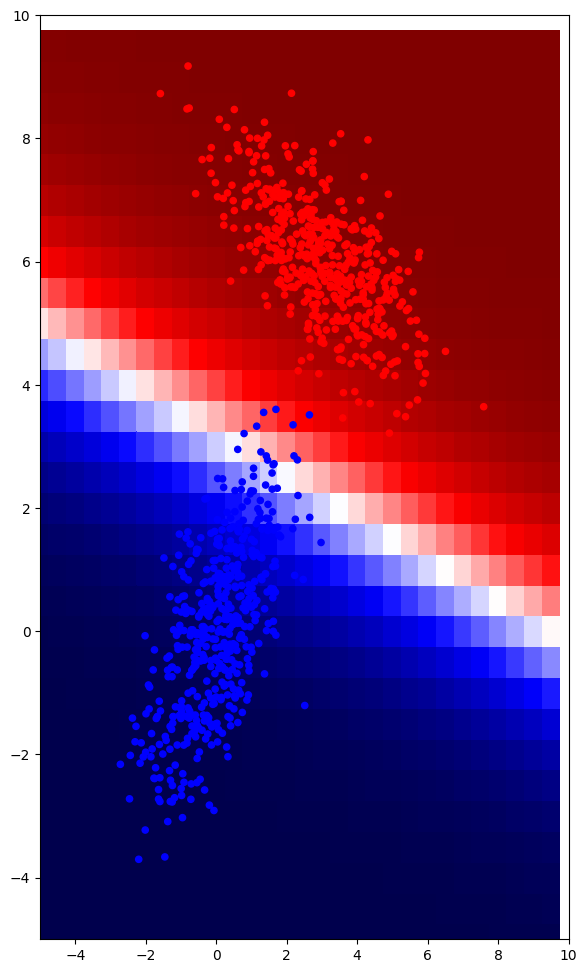

In [20]:
def grad(w,xt,l):
    res = np.zeros(w.shape)
    for x,c in zip(xt,l):
        res += (sigma(w.dot(x))-c) * x
    return res

# Perform gradient descent
w = np.array([0.,-1.,1.])    # Initialise the weights
eta = 1e-3                   # step size
err = error(w,xt,l)           # Compute the error function
errs = []                    # Keep track of the error function

plt.subplot(1,2,1)
for n in range(100  ):         # Run for at most this many iterations
    w -= grad(w,xt,l) * eta   # Update the weights  
    prevError = err; 
    err = error(w,xt,l) 
    print (err,prevError)
    if err > prevError-1e-2: # Abort when the error is not going down enough
        break
    errs.append(err)         # Keep track of how the errors evolved
    if n<10 or n%10==0:
        plotHeat(w)          # plot the probability distribution; comment out to speed things up
        pass
#        plotDisc(w)
# plt.subplot(1,2,2)
# plt.figure()
plt.plot(errs)               # Plot the errors
#plt.title("(extra:) Evolution of the Error function")
#plt.xlabel("Iteration")
#plt.ylabel("Error")

eta

# Stochastic gradient descent

**Question 5** As a last question, implement stochastic gradient descent and compare it to batch gradient descent.


**BATCH gradient descent**


C:\Users\david\AppData\Local\Temp\ipykernel_9344\454065328.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  err += float((1.-c)*w.dot(x) + log1pe(-w.dot(x)))


CPU times: total: 24.6 s
Wall time: 29.6 s
**Stochastic gradient descent**
CPU times: total: 6.69 s
Wall time: 7.56 s


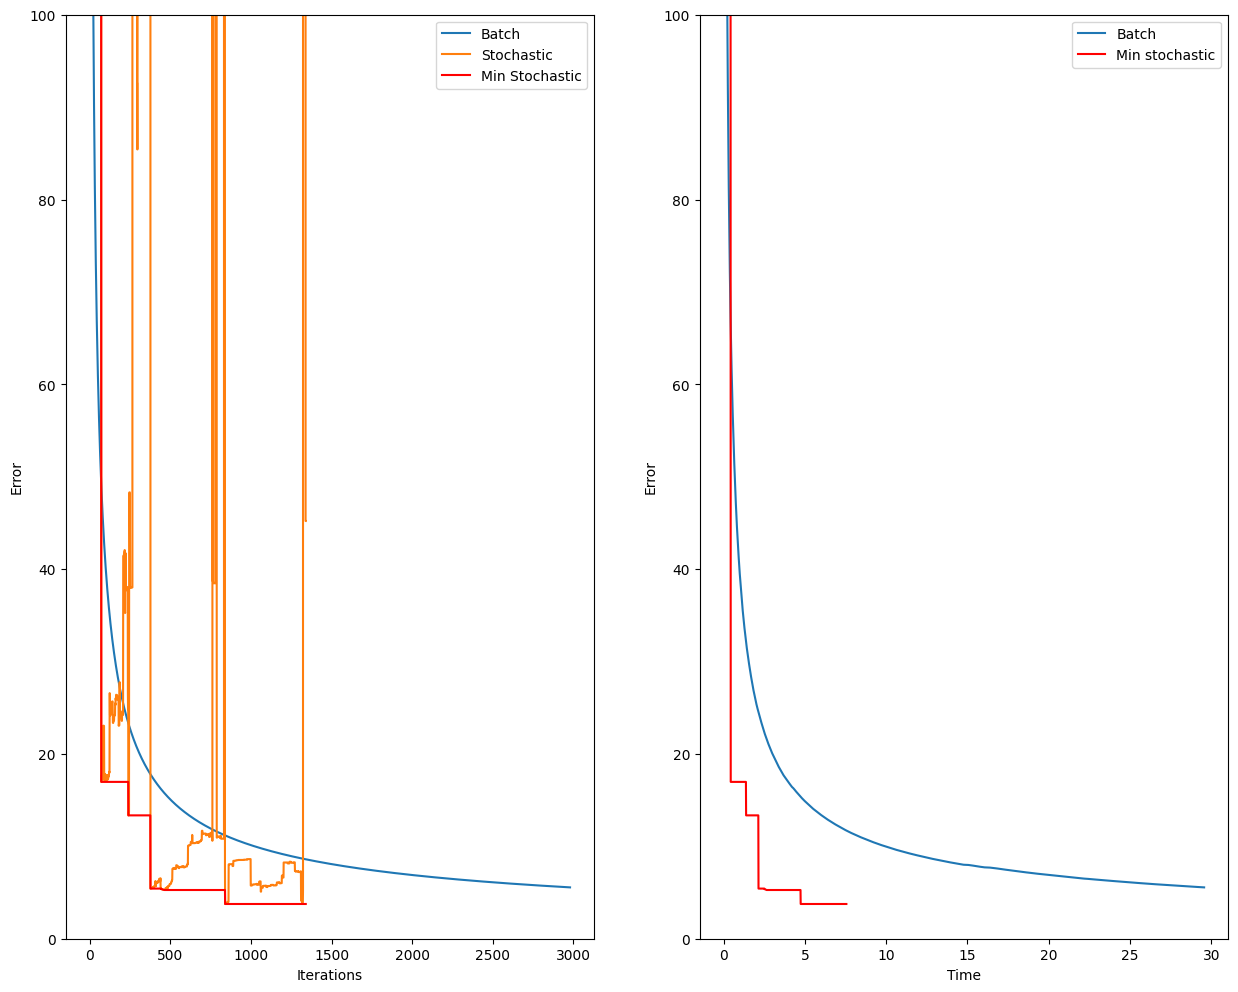

In [8]:
#ANSQ5

elt=0
def grads(w,v,l):
    global elt
    res = (sigma(w.dot(v[elt,:]))-l[elt]) * v[elt,:]
#    elt = (elt+1) % l.size # Cycle through the data
# Alternatively, do "real" stochastic GD, by picking elements at random
    elt = np.random.randint(l.size)
    return res

bestErr = 1e300
bestAge = 0
def convergedStoch(err):
    '''Return True when the error has not gone down more than 500 iterations'''
    global bestErr
    global bestAge
    if err<bestErr:
        bestErr=err
        bestAge=0
    else:
        bestAge+=1
    return bestAge>500

prevErr = np.inf
def convergedBatch(err):
    '''Return True when the error has not gone down more than 1e-3 in the last iteration'''
    global prevErr
    res = err > prevErr - 1e-3
    prevErr = err
    return res

maxit=10000
def gradDesc(w,eta=1e-3, gradfn=grad, conv=convergedBatch):
    err = error(w,xt,l)           # Compute the error function
    errs = np.zeros(maxit)       # Keep track of the error function
    ts = np.zeros(maxit)         # Keep track of time stamps
    start = time.time()

    for n in range(maxit): 
        w -= gradfn(w,xt,l) * eta # Update the weights
        prevError = err; 
        err = error(w,xt,l) 
        if conv(err):            # Abort when converged
            return w, errs[:n], ts[:n]
        errs[n] = err            # Keep track of how the errors evolved
        ts[n] = time.time()-start

    return w, errs, ts


### Compute and Plot the results
import cProfile
pylab.rcParams['figure.figsize'] = (15.0, 12.0) #Large images

print("**BATCH gradient descent**")
%time w,batchErrs,batchTs = gradDesc(np.array([0.,1.,1.]), 1e-3, grad, convergedBatch)
#cProfile.run('w,batchErrs,batchTs = gradDesc(np.array([0.,1.,1.]), 1e-3, grad, convergedBatch)') # Batch GD
print("**Stochastic gradient descent**")
%time w,stochErrs,stochTS = gradDesc(np.array([0.,1.,1.]), 1., grads,convergedStoch)
#cProfile.run('w,stochErrs,stochTS = gradDesc(np.array([0.,1.,1.]), 1., grads,convergedStoch)') # SGD

mn=stochErrs[0]
def minsofar(x):
    global mn
    if x<mn:
        mn=x
    return mn
minSE = [ minsofar(s) for s in stochErrs ] # Create an array with the best error so far for SGD

plt.subplot(1,2,1)
plt.plot(batchErrs)
plt.plot(stochErrs)
plt.plot(minSE, 'r')
plt.ylim([0,100])
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.legend(("Batch","Stochastic", "Min Stochastic"))

plt.subplot(1,2,2)
plt.plot(batchTs, batchErrs)
plt.plot(stochTS, minSE, 'r')
plt.ylim([0,100])
plt.xlabel("Time")
plt.ylabel("Error")
plt.legend(("Batch","Min stochastic"))

#/ANSQ5